In [322]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')


# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12


<img src="mnist_train2.jpg",style="width:600px;height:475px;">

# A concise, conceptual run-through of an MNIST classifier
### By  Agustin Mendoza


### Objective:
This ipython notebook aims to help anyone interested in machine learning by comparing two classifiers. The first classifier that will be introduced implements a hybridized version of bag of words and nearest neighbors classification. The second classifier introduces neural network classification which has grown extremely popular in the recent decade. The order in which the classification methods are presented also has a purpose! Subjectively speaking, building the intuition behind classification is often more difficult when presented with neural network terminology and math. Therefore, we will begin by observing the first aforementioned classifier but we have to make sure we have our data set split. 


## Lets Begin
 There are two csv files included in the zip file one under "train.csv" and the other under "test.csv." For our  purposes, we will just be looking at our "train.csv" file. This should always be the process! We should never include our test data when implementing classifiers otherwise our test data is training data. One thing that readers should note is that these csv files are fairly large and it will take time to load the data into tables. Be patient and restart kernel if it dies. Lets begin by splitting out training data:

In [323]:
full_data = pd.read_csv("train.csv")

#Don't change
np.random.seed(1337) 

# Split the data 
train, test = train_test_split(full_data, test_size=0.2)


Now that we have split our data into train and test categories, lets see how our data looks.

In [324]:
###Looks at the first 5 rows of our dataframe###
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
16666,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8808,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2933,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10798,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21685,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Function that is defined for the bottom cells:

In [325]:
def img_plot(tbl, row):
    pixels = np.array(tbl.iloc[[row]]).flatten()[1:]
    pixels = np.array(pixels, dtype='uint8')
    ###Why do we reshape our row column into a matrix??###
    pixels = pixels.reshape((28, 28))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(pixels, interpolation='nearest',cmap='gray')
    plots.show() 

(Read below before looking at code for a conceptual understanding)

We see that our "label" column has the label of the digit alongside 784 other columns. These other 784 columns describes the "features" of a particular label in pixels. In other words the handwritten number "7" has 784 features that describe why it was classified as a 7. Lets try to make sense of this by visualizing what that means.

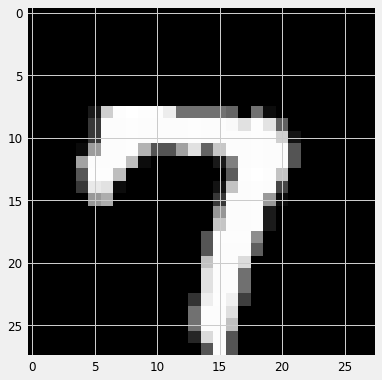

In [326]:
img_plot(train,0)

Here we see that the 784 column values give us an image if we reshape the columns in a matrix of 28x28. Why? If you have not caught on yet, that is alright. What is the result of multiplying 28 by 28? 784! So each feature in our table tells us how "off" or "on" a particular pixel is in a handwritten digit. This "off" and "on" scale is based off of an 8-bit scale so a pixel is completely "off" (black) when it has a value of zero and completely "on" (white) when it has a value of 255.


Now that we have built an intuition of our data, lets continue onto the next step: making sure our training data is distributed fairly for classification.

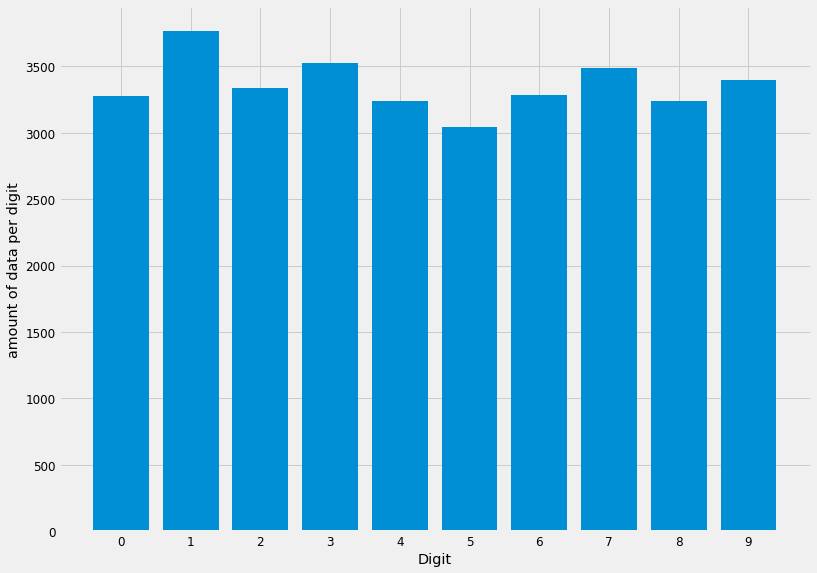

In [327]:
###Gets the counts of each digit###
a = train["label"].value_counts().to_frame()
a.columns = ["count"]
plt.xlabel("Digit")
plt.ylabel("amount of data per digit")
plt.bar(a.index, a["count"], tick_label = a.index);


Although there seems to be a bit more data for some digits, we may proceed onward since the distribution seems to be distributed fairly enough to implement a classifer. If you are bothered by the fact that there is more of a particular value than the others, remove some rows of our training data. However, remove the rows in a random manner so that you are not introducing any sort of bias in the classifier. 

# Classifying our numbers#

Lets begin by looking at the number $\textbf{1}$ alongside 10 features (pixels) that are not "off" (i.e not 0)

In [621]:
table = train[train["label"] == 1]
indices = []
        
for rows1 in np.arange(table.shape[0]):
    a = np.array(table.iloc[rows1])
    ###Finds the indexes that contain pixels that are not completely off###
    indices += [index for index in np.arange(len(a)) if a[index] > 1]

#Finds the pixels that are frequently on most of the time           
lst = collections.Counter(indices).most_common()
#Uses [:10] notation to find the top 10 active pixels in the training data
#Its good to note that we are looking particularly at training data with all ones
#"pixel%d" %lst[:10][i][0] places the value lst[:10][i][0] into the string since our columns are formatted in that way
lstp1 = np.array(["pixel%d" %lst[:10][i][0] for i in np.arange(1,10)])
lstx1 = np.array([int(lst[:10][i][1]) for i in np.arange(1,10)])


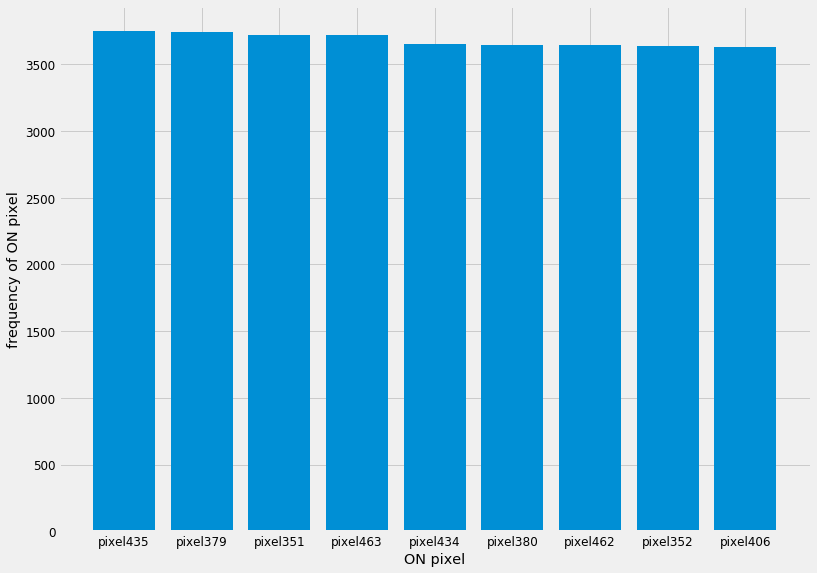

In [329]:
plt.bar(lstp1,lstx1)
plt.xlabel("ON pixel")
plt.ylabel("frequency of ON pixel");

#### $\textbf{What are we doing here?}$ $\textbf{bag of words!}$ 
We are looking for the most common pixels that are not equal to 0. In other words, we are finding most common pixels that are always that are always "on." It might help to visualize this if we plotted the top 50


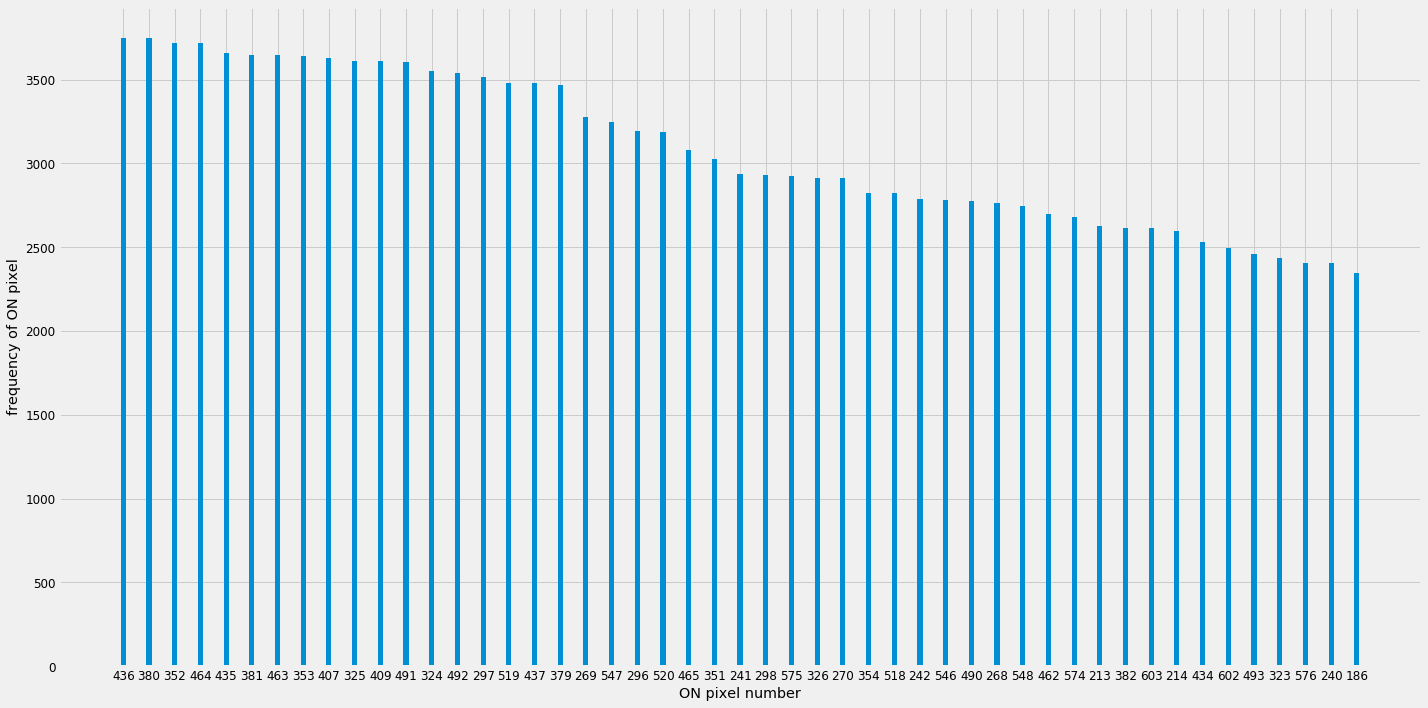

In [330]:
table = train[train["label"] == 1]
indices = []
        
for rows1 in np.arange(table.shape[0]):
    a = np.array(table.iloc[rows1])
    indices += [index+1 for index in np.arange(len(a)) if a[index] > 1]
            
lst = collections.Counter(indices).most_common()
lstp1_50 = np.array([str(lst[:50][i][0]) for i in np.arange(1,50)])
lstx1_50 = np.array([int(lst[:50][i][1]) for i in np.arange(1,50)])

###Plots our data###
fig, ax = plt.subplots(figsize = (20,10))
width = 0.2
ax.bar(lstp1_50,lstx1_50, width=width)
ax.set_xticks(lstp1_50)
plt.xlabel("ON pixel number")
plt.ylabel("frequency of ON pixel");
fig.tight_layout()
plt.show()

Make sure that this makes sense! If we were to plot all the ON pixels, we would see that it would converge to pixels in the training data that only have one ON pixel.

## Functions for classification##
We will now begin writting functions for classification. The first one up is applying our bag of words method for each digit that we have in our training data. We will call this function "kprominentfeatures" which takes in a table (training data) and returns a dictionary of tables. We will observe the a {Key: Value} pair once we run the following function finding the top 300 ON pixels of each digit.

In [347]:
def kprominentfeatures(tbl, k):
    result = {}
    for number in np.arange(10):
        table = tbl[tbl["label"] == number]
        indices = []

        for rows1 in np.arange(table.shape[0]):
            a = np.array(table.iloc[rows1])[1: ]
            indices += [index for index in np.arange(len(a)) if a[index] > 1]
        
        #Finds the pixels that are frequently on most of the time for each number  
        lst = collections.Counter(indices).most_common()
        #Selects the top k features.
        lst = np.array(["pixel%d" %lst[:k][i][0] for i in np.arange(k)])
        #Inserts the number (Key) and the table with the prominent pixels of that number.
        #It should be noted that the table (Value) only contains the training rows of its digit
        #In other words, our table consists of all 5s if number = 5 and has the top k pixels associated with it
        result.update({number : table[lst]})
    
    return result

In [348]:
prom = kprominentfeatures(train, 300)

Now lets observe the table that we retrieve by using the digit $\textbf{1}$.

In [349]:
prom[1].head()

,pixel406,pixel434,pixel378,pixel350,pixel462,pixel433,pixel379,pixel461,pixel351,pixel405,...,pixel664,pixel713,pixel164,pixel102,pixel553,pixel637,pixel525,pixel712,pixel204,pixel344
21685,253,255,253,253,253,253,252,252,252,194,...,0,0,0,0,0,0,0,0,0,0
13093,253,252,252,252,252,252,253,252,253,253,...,0,0,0,0,0,0,0,0,0,0
16428,254,254,254,254,254,254,240,254,218,254,...,0,0,0,0,0,0,0,0,0,0
4181,250,250,252,250,250,252,252,252,250,252,...,0,0,0,0,0,0,0,0,0,0
38443,254,255,255,254,254,160,254,160,226,160,...,0,0,0,0,0,0,0,0,0,0


This table contains all the 1s in our training data and the top 150 ON pixels that we found for that particular digit. This helps us in various ways in terms of classification becaise we are now able to reduce the dimensions of our classifier from 784 to 150.

In [350]:
def fast_distances(test_row, train_rows):
    counts_matrix = np.asmatrix(train_rows)
    diff = np.tile(np.array(test_row.T), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances



def find_min(test_tbl):
    distances = []
    features = {}
    for i in np.arange(10):
        te_row = test_tbl[prom[i].columns].iloc[0].to_frame()
        train_rows = prom[i]
        dist = fast_distances(te_row, train_rows)
        summ = min(dist)
        features.update({summ : i })
        distances.append(summ)
    
    return features[min(distances)]


In [622]:
def find_pixels(classified):
    features = prom[classified]
    x = [] 
    y = [] 
    for i in features:
        pixel_num = int(i[5:])
        row = pixel_num // 28
        column = pixel_num%28
        x.append(column)
        y.append(row)
    return [x,y]
        

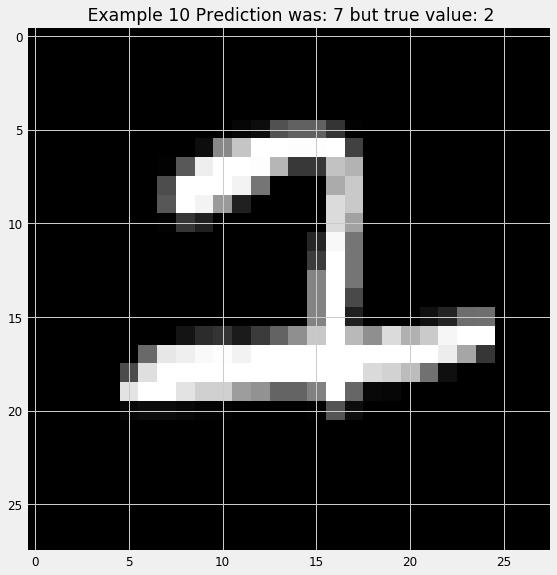

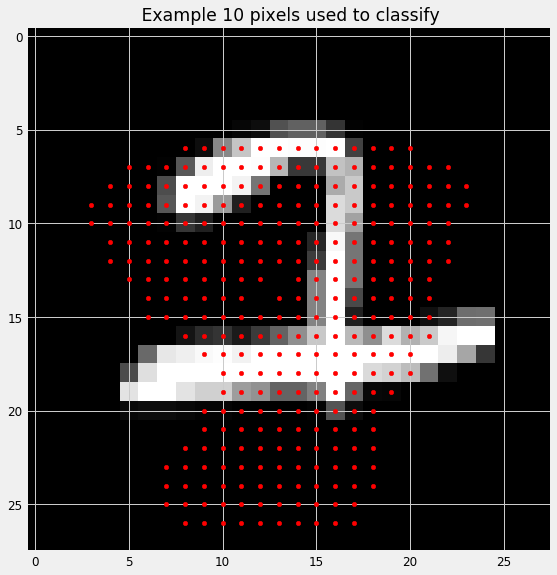

classification accuracy for first 400 images of test data: 94%


In [623]:
result = []

test_classes = test["label"]
test_classes = list(test_classes)
j = 0
k = 400
for i in np.arange(k):  
    classified = find_min(test.iloc[[i]])
    if classified != test_classes[i] and j ==0 :
        #plots the image of the incorrectly classified image
        pixels = np.array(test.iloc[[i]]).flatten()[1:]
        pixels = np.array(pixels, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        plots.title(' Example '+str(i+1)+' Prediction was: {label}'.format(label=classified) + " but true value: " +str(test_classes[i]))
        plots.imshow(pixels, cmap='gray')
        pixs = find_pixels(classified)
        plots.show()   
        #plots the pixels used to classify the incorrect classifier
        plots.title(' Example '+str(i+1)+' pixels used to classify')
        plots.imshow(pixels, cmap='gray')
        pixs = find_pixels(classified)
        plots.scatter(pixs[0], pixs[1], color='red', s=20)
        plots.show()    
        j+=1
    result.append(classified == test_classes[i])


print("classification accuracy for first " +str(k)+" images of test data:" , "{0:.0f}%".format(sum(result)/len(result) * 100))
    
    


Observe that we printed out the first misclassified number and the pixels that were used to classify our information. Note that if you would like to see more misclassified images, we can change the if statement and set j to be less than a certain number. Now lets try to find out why we misclassified this particular number. Note that once we look at this partilcular example, this example becomes part of our training data but this particular example is pedagogical and we will not be trying to improve our classifier from this point on.

Lets visualize this misclassification by plotting the distances that we are computing to find the minimum distance

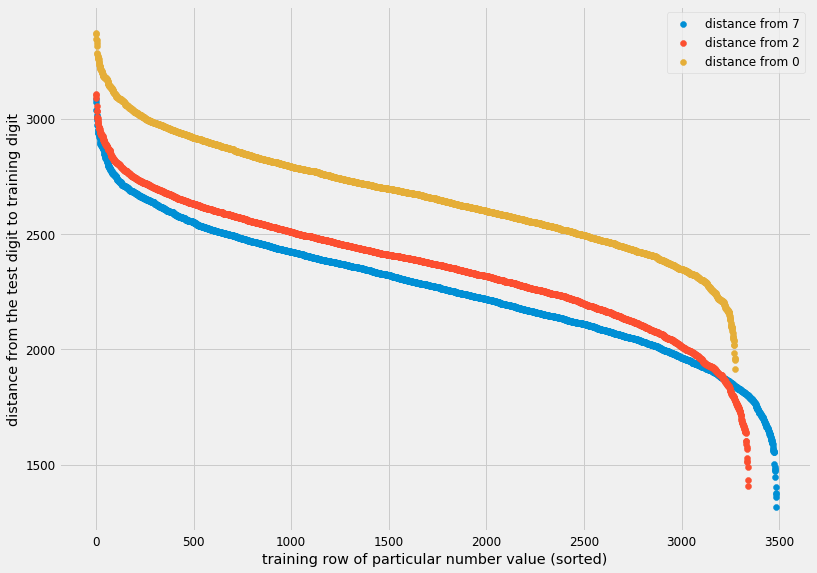

In [353]:
te_row2 = test[prom[2].columns].iloc[9].to_frame()
train_rows2 = prom[2]
distfrom2 = fast_distances(te_row2, train_rows2)

te_row7 = test[prom[7].columns].iloc[9].to_frame()
train_rows7 = prom[7]
distfrom7 = fast_distances(te_row7, train_rows7)

te_row0 = test[prom[0].columns].iloc[9].to_frame()
train_rows0 = prom[0]
distfrom0 = fast_distances(te_row0, train_rows0)

plt.scatter(np.arange(len(distfrom7)),np.sort(distfrom7)[::-1],label= "distance from 7")
plt.scatter(np.arange(len(distfrom2)),np.sort(distfrom2)[::-1], label= "distance from 2")
plt.scatter(np.arange(len(distfrom0)),np.sort(distfrom0)[::-1], label= "distance from 0")
plt.xlabel("training row of particular number value (sorted)")
plt.ylabel("distance from the test digit to training digit")
plt.legend();

Disregarding the distance from 0 that was thrown in to help visualize, we can see that the distance from 2 and the distance from 7 are just about neck and neck in terms of finding a minimum. We will now look at the neck and neck images that we used to classify our test digit.

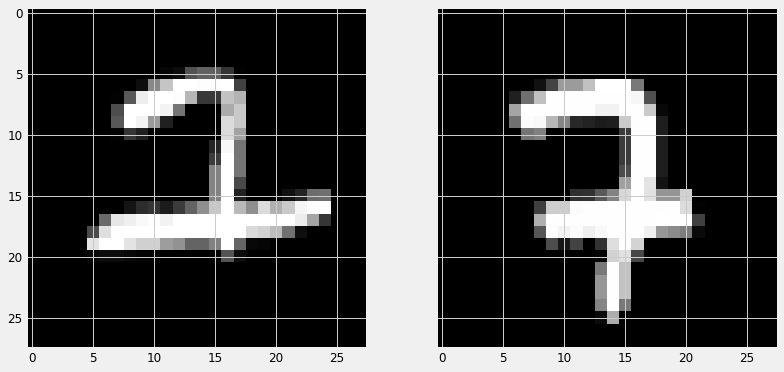

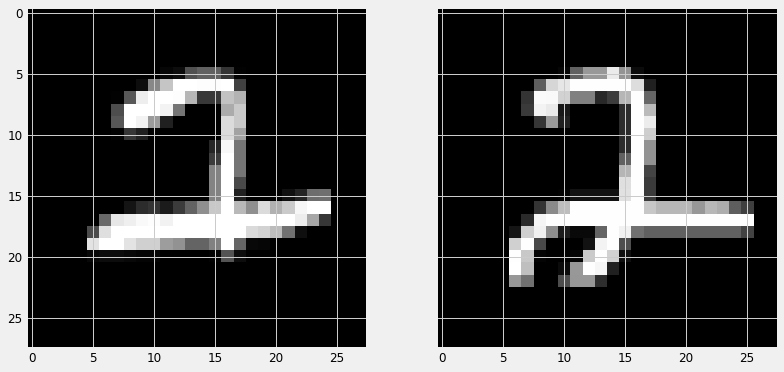

In [362]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
pixels2 = np.array(test.iloc[[9]]).flatten()[1:]
pixels2 = np.array(pixels2, dtype='uint8')
pixels2 = pixels2.reshape((28, 28))
ax1.imshow(pixels2, interpolation='nearest',cmap='gray')
pixels7 = np.array(train[train["label"]==7].iloc[np.where(distfrom7 == np.min(distfrom7))[0][0]]).flatten()[1:]
pixels7 = np.array(pixels7, dtype='uint8')
pixels7 = pixels7.reshape([28,28])
ax2.imshow(pixels7,interpolation='nearest',cmap='gray');


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
pixels2 = np.array(test.iloc[[9]]).flatten()[1:]
pixels2 = np.array(pixels2, dtype='uint8')
pixels2 = pixels2.reshape((28, 28))
ax1.imshow(pixels2, interpolation='nearest',cmap='gray')
pixels2 = np.array(train[train["label"]==2].iloc[np.where(distfrom2 == np.min(distfrom2))[0][0]]).flatten()[1:]
pixels2 = np.array(pixels2, dtype='uint8')
pixels2 = pixels2.reshape([28,28])
ax2.imshow(pixels2,interpolation='nearest',cmap='gray');

What can be said about our findings? Perhaps we can conclude that the misclassification was caused because the minimum training image of the 7 shared more pixels in common (closer in ON value) than the all other minimums. Lets see if we can validate this argument.

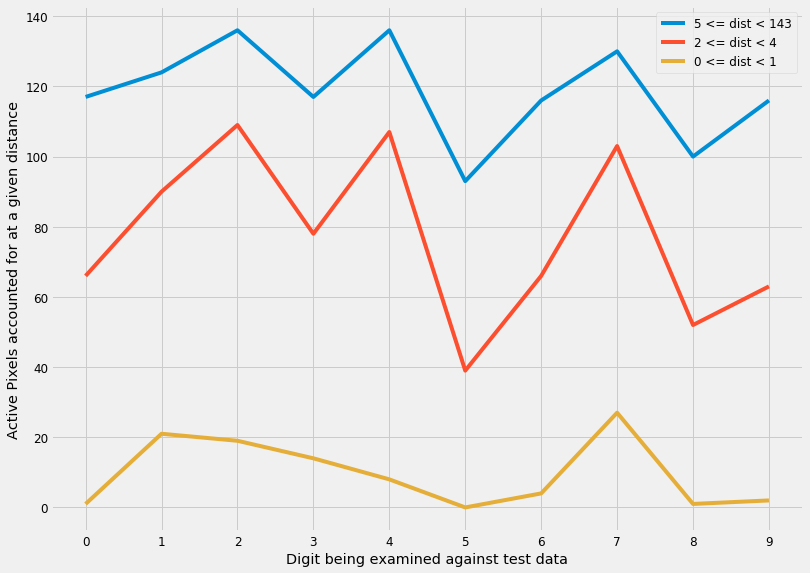

In [616]:
def plotclosestdistancesdist(row,train,rtol,atol):
    a = np.array(row).flatten()[1:]
    indices = []
    indices += [index for index in np.arange(len(a)) if a[index] > 1]          
    lst = collections.Counter(indices).most_common()
    lst = np.array(["pixel%d" %lst[i][0] for i in np.arange(len(lst))])
    st = row.index[0]


    sortedt = row[lst].T.sort_values(st)
    lst = np.array(sortedt.index)
    x = np.array(row[lst]).flatten()
    s = []
    for i in np.arange(10):
        te_row = test[prom[i].columns].loc[row.index[0]].to_frame()
        train_rows = prom[i]
        dist = fast_distances(te_row, train_rows)
        digit = train[train["label"]==i].iloc[np.where(dist == np.min(dist))]
        digit = np.array(digit[lst]).flatten()
        distribution = np.sum(np.isclose(x,digit,rtol,atol))
        s.append(distribution)
    plt.plot(np.arange(len(s)),s, label = str(rtol)+" <= dist < "+ str(atol))
    plt.xticks(np.arange(10))
    plt.legend()

plotclosestdistancesdist(test.iloc[[9]],train,5,143)
plotclosestdistancesdist(test.iloc[[9]],train,2,4)
plotclosestdistancesdist(test.iloc[[9]],train,0,1)
plt.xlabel("Digit being examined against test data")
plt.ylabel("Active Pixels accounted for at a given distance");

What this graph above shows us is that the misclassified test data (ie. the 2 digit misclassified as a 7) was influenced mostly in part by the 20+ active pixels that were 0 to 1 unit of light away from the actual value of the 7-digit classifier. The red and blue plots show that 2,4 and 7 all have similar distributions of active pixels once the distances between them are 2 or 3. The only reason why the 7-digit classifier won the race is because of the amount for pixels accounted for at a distance of 0 or 1 which validates the aforementioend argument.

It is now time to run the classifier on all the test data to see the level of accuracy acheived (WARNING: THIS WILL TAKE A WHILE):

In [608]:
result = []

test_classes = test["label"]
test_classes = list(test_classes)
k = len(test_classes)
for i in np.arange(k):  
    classified = find_min(test.iloc[[i]])
    result.append(classified == test_classes[i])


print("classification accuracy for all images of test data:" , "{0:.0f}%".format(sum(result)/len(result) * 100))
    

classification accuracy for all images of test data: 94%


# Conclusion:


For this particular batch of test data, we see that we have classified our test data of size 8400 correctly 94% of the time. Despite the performance of our classifier not being up to par with a neural network, we can see that we are just 6% away from 100% accuracy which is pretty impressive given that we are actually able to visualize the proccess that is taking place. 